# Информационные системы Беларуси
Данные скачены __2021-08-18__ из [Государственного регистра информационных систем](http://грис.бел/app/registerIS) (далее - ГРИС) через [инструменты](https://developer.mozilla.org/ru/docs/Tools/Tools_Toolbox) разработчика браузера __*Mozilla Firefox*__ и сохранены в формате `.xlsx`.

В этом проекте __*Jupiter*__ представлены результаты анализа скаченых данных.

## 1. Подготовка к анализу

### Импортируем необходимые для анализа библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

### Загружаем данные в проект 

In [2]:
file = 'db/IS_list.xlsx' # файл представляет собой таблицу из столбцов (параметры) и строк (информационные ресурсы)
date_parser = lambda x: datetime.strptime(x, '%d.%m.%Y') # определяем формат даты
data = pd.read_excel(file, 
                     header=0, # название столбцов в первой строке (заметка: в Python отсчет начинается с 0, а не 1)
                     parse_dates=['Дата гос. Регистрации', 'Дата исключения', 'Дата актуализации'], # содержат дату
                     date_parser=date_parser, 
                     na_values='') # пустые поля обозначаем 'NA' для Python

### Проверяем структуру файла

In [3]:
rows = data.shape[0]
columns = data.shape[1]
print(f'Количество строк: {rows}\nКоличество столбцов: {columns}\n')

Количество строк: 373
Количество столбцов: 19



### Выводим названия столбцов

In [4]:
data_cols = data.columns.tolist()
print(*data_cols, sep = '\n')

Полное наименование ИС
Краткое наименование ИС
Номер свидетельства
Дата гос. Регистрации
Дата свидетельства
Заявитель
Владелец
Разработчик
Собственник
Заказчик
Оператор
Назначение
Основные функции
Размер
Структура
Форма собственности
Хар-р решаемых задач
Дата исключения
Дата актуализации


### Исключаем ненужные для анализа столбцы
Для целей анализа не пригодятся следующие данные: 
* краткие наименование информационных систем - дублируют информацию из полного наименования
* номер свидетельства - дополнительной информации не несет
* дата свидетельства - практически совпадает с датой государственной регистрации
* заявитель - малоинформативно, потому как часто указывается имя должностного лица организации
* заказчик - малоинформативно, потому как впоследствии ИС управляется его владельцем
* основные функции - сведения детализируют столбец "назначение"
* дата актуализации - малоинформативно потому как информационная система не добавляется и не удаляется из регистра

In [5]:
data.drop(columns=['Краткое наименование ИС', 
                   'Номер свидетельства', 
                   'Дата свидетельства', 
                   'Заявитель',
                   'Заказчик',
                   'Основные функции',
                   'Дата актуализации'], 
          inplace=True)

### Проверяем таблицу на полноту данных

In [6]:
data.isnull().sum() 

Полное наименование ИС      0
Дата гос. Регистрации       0
Владелец                    0
Разработчик                 1
Собственник                 1
Оператор                   64
Назначение                  0
Размер                      2
Структура                   1
Форма собственности         0
Хар-р решаемых задач        2
Дата исключения           354
dtype: int64

*__Итак__, данные не полные:*
* сведения о разработчике, собственнике и структуре информационной системы не указаны по одному разу
* в двух строках не указаны размер финансирования и характер решаемых задач информационных систем
* в одинадцати случаях не указан заказчик
* сведения об операторе не указаны в 64 случаях, но отметим, что наличие оператора не обязательно
* отсутствие сведений о дате исключения говорит о том, что информационная система продолжает функционировать

### Переименовываем столбцы в необходимые для анализа значения

In [7]:
df = data.rename(columns={'Полное наименование ИС':'name', # создаем копию базы данных 'data'  
                'Дата гос. Регистрации':'reg_date',        # с новыми названиями столбцов - 'df'
                'Владелец':'holder', 
                'Разработчик':'developer', 
                'Собственник':'owner',
                'Оператор':'controller', 
                'Назначение':'purpose',  
                'Размер':'budget',
                'Структура':'structure',
                'Форма собственности':'ownership',
                'Хар-р решаемых задач':'tasks',
                'Дата исключения':'excl_date'})

### Выводим строки без сведений о разработчике, собственнике, структуре, размере финансирования и характере решаемых задач

In [8]:
filt = (df.developer.isnull()) |\
       (df.owner.isnull()) |\
       (df.structure.isnull()) |\
       (df.budget.isnull()) |\
       (df.tasks.isnull())

df.loc[filt, ['name', 'holder', 'developer', 'owner', 'structure', 'budget', 'tasks']]

,name,holder,developer,owner,structure,budget,tasks
120,"Информационный ресурс ""Реестр оплаченных плате...",Верховный Суд РБ,NaN,Республика Беларусь,Территориально распределенная ИС с единой базо...,Мини-ИС (стоимость ИС до 10 000 руб.),ИС информационного обеспечения определенного в...
190,"Автоматизированная информационная система ""Бух...","УЗ ""Городская клиническая больница скорой меди...","ЗАО ""МАПСОФТ""",г.Минск,Локальная ИС (на основе локальной вычислительн...,NaN,ИС информационного обеспечения определенного в...
244,"Автоматизированная информационная система ""Пол...","УЗ ""34-я поликлиника г. Минска""","ЗАО ""МАПСОФТ""",NaN,Локальная ИС (на основе локальной вычислительн...,Средняя ИС (стоимость ИС от 50 000 руб. до 200...,ИС информационного обеспечения определенного в...
264,Автоматизированная система учета и распределен...,Упр.жилищной политики Мингорисполкома,"КУП ""Центр информационных технологий Мингорисп...",Республика Беларусь,Территориально распределенная ИС с распределен...,NaN,ИС информационного обеспечения определенного в...
320,Информационная система корпоративной информаци...,Могилевский облисполком,"Государственное предприятие ""Могилевский регио...",Республика Беларусь,Территориально распределенная ИС с единой базо...,Малая ИС (стоимость ИС от 10 000 руб. до 50 00...,NaN
327,Информационно аналитическая система Конституци...,Конституционный Суд Республики Беларусь,"НИРУП ""ИППС""",Республика Беларусь,NaN,Средняя ИС (стоимость ИС от 50 000 руб. до 200...,АСУ предприятием (АСУП)
336,Первая очередь региональной автоматизированной...,Брестский облисполком,БГУИР,Республика Беларусь,Территориально распределенная ИС с единой базо...,Средняя ИС (стоимость ИС от 50 000 руб. до 200...,NaN


__Обращаем внимание__, что строки без данных (`NaN`) при анализе не используются, что необходимо учитывать при интерпретации результатов 

### Количество действующих информационных систем

In [9]:
total_is = df.shape[0]
excl_n = df.excl_date.count()
excl_share = excl_n / df.shape[0] * 100
current_is = total_is - excl_n
current_is_share = (total_is - excl_n) / df.shape[0] * 100
print("""Общее количество информационных систем - {}, из них:
действующих - {}, что составляет {:4.2f}%
исключенных - {}, что составляет {:4.2f}%""".format(total_is, current_is, current_is_share, excl_n, excl_share))

Общее количество информационных систем - 373, из них:
действующих - 354, что составляет 94.91%
исключенных - 19, что составляет 5.09%


## 2. Динамика регистрации в ГРИС

### Динамика регистрации ГРИС по годам

In [10]:
y_reg = df.groupby(df.reg_date.dt.year).count()
y_excl = df.groupby(df.excl_date.dt.year).count()

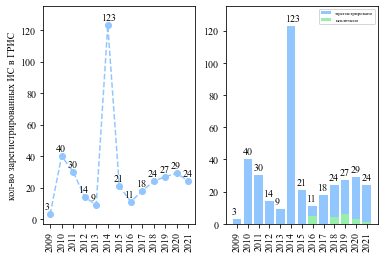

In [11]:
plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(1, 2)
ax[0].plot(y_reg.index, y_reg.name, marker='o', linestyle="--")
ax[0].set_ylabel("кол-во зарегистрированных ИС в ГРИС")
ax[0].set_xticks(y_reg.index)
ax[0].tick_params(axis='x', labelrotation=90)
for year, num in y_reg.iterrows():
    ax[0].text(x=year-0.5, y=int(num[0])+3, s=f'{int(num[0])}')
ax[0].set_ylim(top=135)
ax[1].bar(y_reg.index, y_reg.name)
ax[1].bar(y_excl.index, y_excl.name)
ax[1].set_xticks(y_reg.index)
ax[1].tick_params(axis='x', labelrotation=90)
for year, num in y_reg.iterrows():
    ax[1].text(x=year-0.5, y=int(num[0])+3, s=f'{int(num[0])}')
ax[1].set_ylim(top=135)
ax[1].legend(['зарегистрировано', 'исключено'], fontsize=5)
plt.savefig('pics/p1-din_double.png', dpi=600)
plt.show()

### Динамика регистрации ГРИС по месяцам

In [12]:
df_date = df.set_index('reg_date')
df_date = df_date.resample('M').name.count()
df_date.idxmax() # определяем индекс максимального значения

Timestamp('2014-08-31 00:00:00', freq='M')

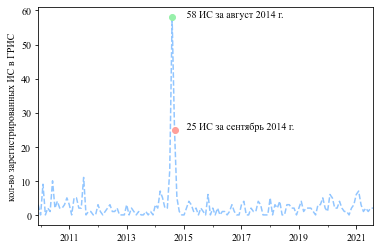

In [13]:
df_date.plot(linestyle='dashed')
df_date[56:57].plot(marker='o')
df_date[57:58].plot(marker='o')
plt.text(x=540, y=58, s=f' 58 ИС за август 2014 г.')
plt.text(x=540, y=25, s=f' 25 ИС за сентябрь 2014 г.')
plt.xlabel('')
plt.ylabel('кол-во зарегистрированных ИС в ГРИС')
plt.savefig('pics/p2-din.png', dpi=600)
plt.show()

## 3. Субъектный состав информационных отношений 

### Выводим список владельцев информационных систем

In [14]:
print('Количетсов владельцев ИС:', df.holder.unique().shape[0])

Количетсов владельцев ИС: 190


In [15]:
df.holder.sort_values().unique()[:20]

array(['"НАЦИОНАЛЬНАЯ КНИЖНАЯ ПАЛАТА РБ"',
       '1-я городск.клиническая больница',
       '11-я городская клиническая больница',
       '11-я городская поликлиника', '12-я городская детская поликлиника',
       '18-я городская поликлиника', '19-я городская детская поликлиника',
       '22-я городская поликлиника', '23-я городская детская поликлиника',
       '3-Я ГОР.ДЕТСКАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА',
       '31-я ГОРОДСКАЯ ПОЛИКЛИНИКА',
       '9-я городская детская поликлиника г.Минска', 'Bolt Technology OU',
       'Yandex.Taxi B.V. (Яндекс.Такси Б.В.)', 'Академия управления',
       'ББТС', 'БГУКИ', 'БарГУ', 'БелГИСС', 'БелИСА'], dtype=object)

Заметим, что владельцев информационных систем можно распределить по категориям

### Создаем категории владельцев информационных систем

In [16]:
df['holder_cat'] = df.holder
strings = ['Суд|Палаты', 
           'Министерство|Департамент|комитет|Госкомимущество|внутренних|МВД|МНС|МПРООС|МФ|Минздрав|Минлесхоз|Минэкономики|УГАИ|Концерн',
           'КНИЖНАЯ|ББТС|БелГИСС|БелИСА|Белгеодезия|Белгослес|документации|Белстат|ГИАЦ|ИНСПЕКЦИЯ|хозяйственное|Госстандарт|Информационно-издательский|НБРБ|НИРУП|НПОДО|НЦПИ|идентификации|трафиком|РГОО|РНИУП|гидрометеорологии|Белсоюзпечать|социальной|животноводстве|Белэнерго|РУП |Белтехосмотр',
           'Облисполком|облисполком|КУП|Минсктранс|МИНГОРИСПОЛКОМА|Мингорисполкома|Гомельэнерго|облсельхозпрода', 
           'больница|поликлиника|БОЛЬНИЦА|ПОЛИКЛИНИКА|медицинск|диспансер|ЦГ и Э|РНПЦ МТ|РПБ Гайтюнишки|10-я ГКБ|14-я ГСП|4ГДКБ|6-я ЦРКП г.Минска|Амбулатория №1|ВОДЦ|родильный дом|медико-реабилитационная|ГССМП|МККДЦ|25-я ЦРП', 
           'Академия|БГУКИ|БарГУ|УО|НАНБ|НАН|геологии', 
           'ООО|Частное|ЧПУП|ЧТУП|Парахня|Казанцев|ЗАО|ОАО|Bolt|Yandex']

cats = ['парламент и суд', 
        'правительство', 
        'республиканские организации', 
        'местное управление', 
        'здравоохранение', 
        'образование и наука', 
        'предпринимательство']

for st, cat in zip(strings, cats):
    df.loc[df['holder_cat'].str.contains(st, regex=True, na=None), 'holder_cat'] = cat

df.holder_cat = pd.Categorical(df.holder_cat, 
                               ordered=True, 
                               categories=cats)

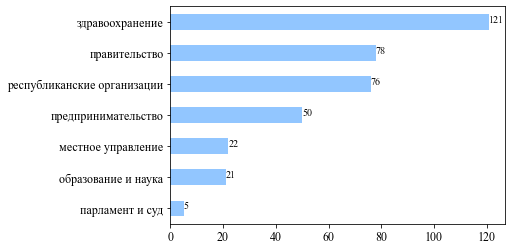

In [17]:
cats_count = df.holder_cat.value_counts(ascending=True)
cats_count.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(cats_count):
    plt.text(y=count, x=int(row), s=f"{int(row)}")
plt.show()

## 4. Соотнесение основных параметров

### Соотношение владельцев ИС в зависимости от формы собственности

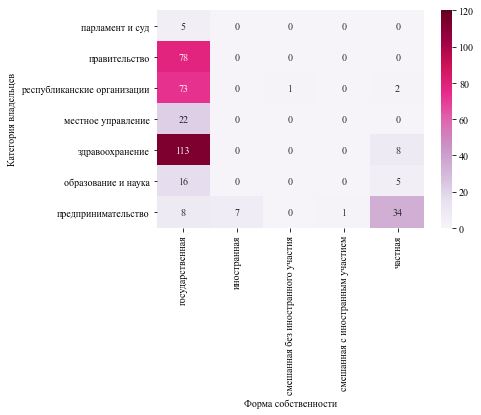

In [18]:
own_holders = pd.crosstab(df.holder_cat, df.ownership)
ax = sns.heatmap(data=own_holders, annot=True, cmap='PuRd', fmt='g', vmax=120)
ax.set(xlabel='Форма собственности', ylabel='Категория владельцев')
plt.show()

### Упорядочиваем информацию о размерах финансирования ИС

In [19]:
df['budget'] = df['budget'].map({'Мега-ИС (стоимость ИС свыше 400 000 руб.)': 'мега',
                                     'Большая ИС (стоимость ИС от 200 000 руб. до 400 000 руб.)': 'большая',
                                     'Средняя ИС (стоимость ИС от 50 000 руб. до 200 000 руб)': 'средняя', 
                                     'Малая ИС (стоимость ИС от 10 000 руб. до 50 000 руб.)': 'малая',                                      
                                     'Мини-ИС (стоимость ИС до 10 000 руб.)': 'мини',
                                     'Категория ИС в зависимости от объема финансирования': 'неизвестно'}, 
                                na_action='ignore')

df['budget'] = pd.Categorical(df['budget'], 
                               ordered=True, 
                               categories=['мега', 'большая', 'средняя', 'малая', 'мини', 'неизвестно'])

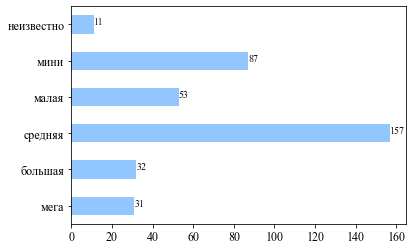

In [20]:
budget_count = df.budget.value_counts(sort=False)
budget_count.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(budget_count):
    plt.text(y=count, x=int(row), s=f"{int(row)}")
plt.show()

### Соотношение владельцев ИС в зависимости от размера финансирования ИС

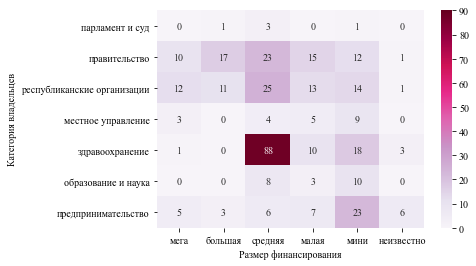

In [21]:
size_holders = pd.crosstab(df.holder_cat, df.budget)
ax = sns.heatmap(data=size_holders, annot=True, cmap='PuRd', fmt='g', vmax=90)
ax.set(xlabel='Размер финансирования', ylabel='Категория владельцев')
plt.show()

### Упорядочиваем информацию о структуре ИС

In [22]:
df['structure'] = df['structure'].map({'Локальная ИС (на основе локальной вычислительной сети)': 'локальная',
                                   'Нет подходящего вида структур ИС': 'неизвестно',
                                   'Однопользовательская ИС': 'однопользовательская', 
                                   'Территориально распределенная ИС с единой базой данных': 'распределенная',                                      
                                   'Территориально распределенная ИС с распределенными базами данных': 'распределенная',
                                  }, na_action='ignore')

df['structure'] = pd.Categorical(df['structure'], 
                               ordered=True, 
                               categories=['распределенная', 
                                           'локальная', 
                                           'однопользовательская', 
                                           'неизвестно'])

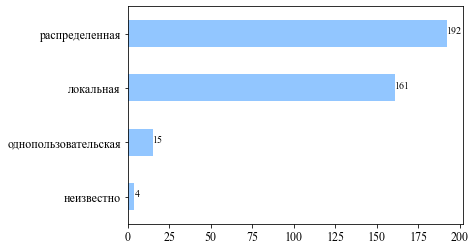

In [23]:
struct_count = df.structure.value_counts(ascending=True)
struct_count.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(struct_count):
    plt.text(y=count, x=int(row), s=f"{int(row)}")
plt.show()

### Соотношение владельцев ИС в зависимости от структуры ИС

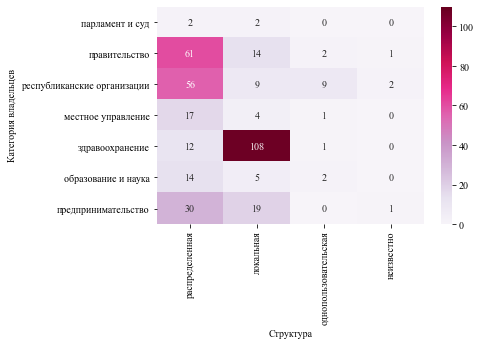

In [24]:
struct_holders = pd.crosstab(df.holder_cat, df.structure)
ax = sns.heatmap(data=struct_holders, annot=True, cmap='PuRd', fmt='g', vmax=110)
ax.set(xlabel='Структура', ylabel='Категория владельцев')
plt.show()

### Соотношение размера финансирования и структуры ИС

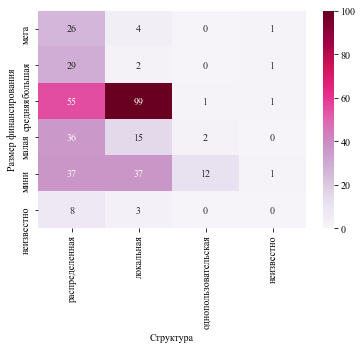

In [25]:
size_structure = pd.crosstab(df.budget, df.structure)
ax = sns.heatmap(data=size_structure, annot=True, cmap='PuRd', fmt='g', vmax=100)
ax.set(xlabel='Структура', ylabel='Размер финансирования')
plt.show()

### Примеры распределенные мега проектов

In [26]:
mega_projects = df.loc[(df.budget == 'мега') & (df.structure == 'распределенная'), ['name', 'holder']] 

In [27]:
mega_projects[:5]

,name,holder
8,Единая государственная автоматизированная инфо...,Белгослес
9,Автоматизированная информационная система Реги...,"ООО ""Центр цифровых транспортных технологий"""
10,Автоматизированная информационная система Элек...,"ООО ""Центр цифровых транспортных технологий"""
23,Информационная система «Платформа Bolt»,Bolt Technology OU
26,Автоматизированная информационная система обра...,РНПЦ МТ


## 6. Иные субъекты

### Топ-10 разработчиков ИС

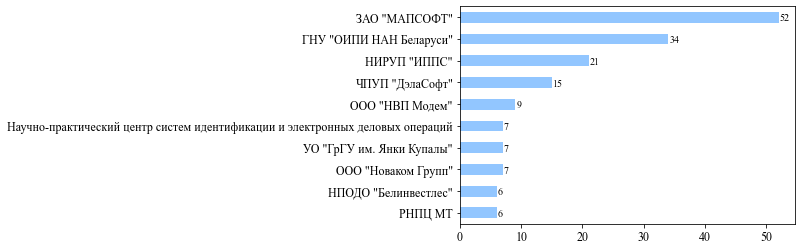

In [28]:
top_10_devs = df.developer.value_counts()[:10].to_frame()
top_10_devs = top_10_devs.iloc[::-1]
top_10_devs.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(top_10_devs.values):
    plt.text(y=count-0.15, x=int(row)+0.2, s=f"{int(row)}")
plt.show()

### Топ-10 собственников ИС

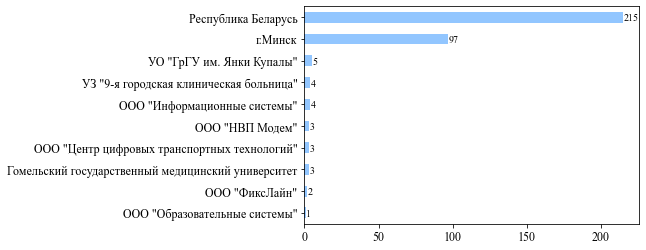

In [29]:
df.loc[df['owner'] == 'г. Минск', 'owner'] = 'г.Минск'
top_10_owners = df.owner.value_counts()[:10].to_frame()
top_10_owners = top_10_owners.iloc[::-1]
top_10_owners.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(top_10_owners.values):
    plt.text(y=count-0.15, x=int(row)+0.2, s=f"{int(row)}")
plt.show()

### Топ-10 операторов ИС

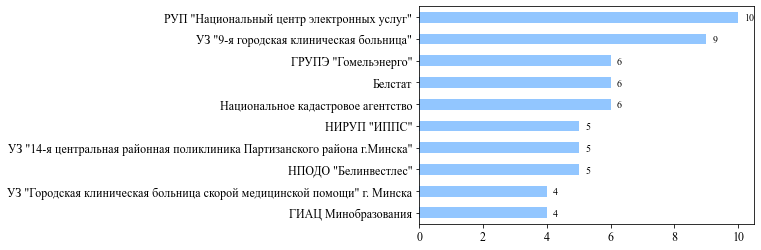

In [30]:
top_10_controllers = df.controller.value_counts()[:10].to_frame()
top_10_controllers = top_10_controllers.iloc[::-1]
top_10_controllers.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(top_10_controllers.values):
    plt.text(y=count-0.15, x=int(row)+0.2, s=f"{int(row)}")
plt.show()

## 6. "Секрет" успеха здравоохранения

Данные показывают, что безусловным лидером в информатизации являются учреждения здравоохранения. Именно поэтому мы и выделили их в отдельную категорию. Однако, чтобы убедиться в этом проверим названия информационных систем. 

### Повторяющиеся цели ИС

In [31]:
df.purpose.value_counts()[:10].to_frame()

,purpose
"Основным назначением АИС ""Поликлиника"" является информационная поддержка лечебно-диагностического процесса и эффективного осуществления функций учреждения здравоохранения поликлинического типа за счет управления информационными потоками, сбора, анализа и обработки данных, получаемых в результате обследований и лечения пациентов.",17
"Главным назначением АИАС ""Клиника"" является информационная поддержка лечебно-диагностического процесса и эффективного осуществления функций учреждения здравоохранения стационарного типа за счет управления информационными потоками, сбора, анализа и обработки данных, получаемых в результате обследований и лечения стационарных и амбулаторных больных и сопутствующих документов",9
"Основным назначением АИС ""Бухгалтерский учет"" является информационная поддержка оперативного учета состояния и движения личного состава, учета труда, расчета заработной платы, комплексное ведение учета медикаментов в стационаре, продуктов питания и других материальных ценностей, учета финансовых операций с формированием Баланса в учреждениях, финансируемых из бюджета.",7
"Информационная система предназначена для использования диспетчерами такси или автомобильными перевозчиками с целью автоматизации процесса выполнения автомобильных перевозок пассажиров автомобилями-такси путем обеспечения возможности приема и распределения заказов на автомобильные перевозки on-line, а также проведения безналичных расчетов за совершенные автомобильные перевозки.",5
"Главным назначением АИС ""DELTA+ Персонал"" является учёт сведений о сотрудниках учреждения здравоохранения, подготовка документации (приказы, контракты и прочие), создание документов персонифицированного учёта, статистических отчетов.",4
"Главным назначением АИАС ""Стоматология"" является информационная поддержка лечебно-диагностического процесса и эффективного осуществления функций учреждения здравоохранения стоматологического профиля за счет управления информационными потоками, сбора, анализа и обработки данных, получаемых в результате обследований и лечения амбулаторных пациентов и сопутствующих документов",4
"Основным назначением АИС ""Поликлиника"" является информационная поддержка лечебно-диагностического процесса и эффективного осуществления функций учреждения здравоохранения поликлинического типа за счет управления информационными потоками, сбора, анализа и обработки данных, получаемых в результате обследований и лечения пациентов",3
Автоматизация диспетчерских служб такси и on-line заказ автомобилей-такси через приложение,3
"Основным назначением АИС ""Бухгалтерский учет"" является информационная поддержка оперативного учета состояния и движения личного состава, учета труда, расчета заработной платы, комплексное ведение учета медикаментов в стационаре, продуктов питания и других материальных ценностей, учета финансовых операций с формированием Баланса в учреждениях, финансируемых из бюджета",3
"Основным назначением АИС «Поликлиника» является информационная поддержка лечебно-диагностического процесса и эффективного осуществления функций учреждения здравоохранения поликлинического типа за счет управления информационными потоками, сбора, анализа и обработки данных, получаемых в результате обследований и лечения пациентов",2


In [32]:
is_health_names = df.loc[df.holder_cat == 'здравоохранение', 'name']

acc_health = is_health_names[is_health_names.str.contains('Бухгалтер|Персонал|\"Клиника\"|\"Стоматология\"|\"Поликлиника\"', 
                                                          regex=True)].count()
print('Количество бухгалтерских, кадровых и типовых ИС:', acc_health)

Количество бухгалтерских, кадровых и типовых ИС: 68


Место категории 'здравоохранение' без бухгалтерских, кадровых и типовых ИС:

In [33]:
check_healthcate = df.holder_cat.value_counts().to_frame()
check_healthcate.reset_index(inplace=True)
check_healthcate.rename(columns={'index':'категория', 'holder_cat':'кол-во ИС'}, inplace=True)
check_healthcate.iloc[0, 1] = check_healthcate.iloc[0, 1] - acc_health
check_healthcate = check_healthcate.set_index('категория').sort_values('кол-во ИС', ascending=True)

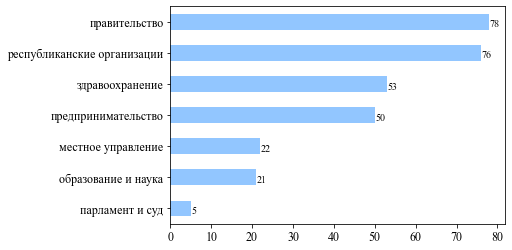

In [34]:
check_healthcate.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(check_healthcate.values):
    plt.text(y=count-0.15, x=int(row)+0.2, s=f"{int(row)}")
plt.show()

## 7. Задачи ИС

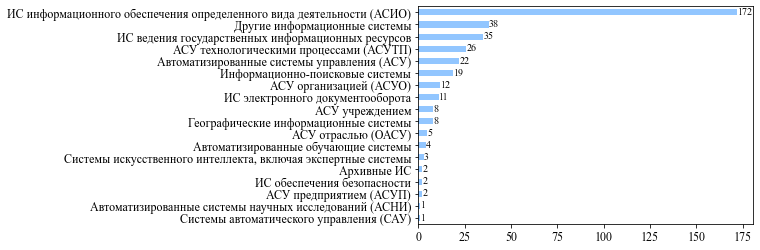

In [35]:
tasks_plot = df.tasks.value_counts(ascending=True)

tasks_plot.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(tasks_plot.values):
    plt.text(y=count-0.15, x=int(row)+0.2, s=f"{int(row)}")
plt.show()

### Определяем основные ИС исходя из категории владельцев и выполняемых ИС задач

In [36]:
filt = ((df.tasks != 'АСУ организацией (АСУО)') \
        | (df.tasks != 'АСУ учреждением') \
        | (df.tasks != 'Автоматизированные обучающие системы') \
        | (df.tasks != 'Архивные ИС') \
        | (df.tasks != 'АСУ предприятием (АСУП)')) \
        & ((df.holder_cat == 'правительство') \
        | (df.holder_cat == 'республиканские организации') \
        | (df.holder_cat == 'местное управление') \
        | (df.holder_cat == 'парламент и суд')) # исключаем локальные по характеру задач системы
                                                # оставляем только органы государственного управления
main_is = df.loc[filt]
print('Количество основных ИС: ', main_is['name'].shape[0])

Количество основных ИС:  181


## Топ-10 владельцев основных ИС

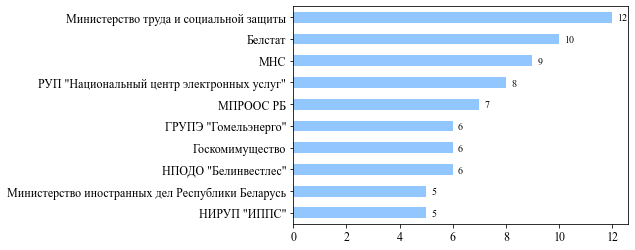

In [37]:
top_10_main_holders = main_is.holder.value_counts()[:10].to_frame().sort_values('holder', ascending=True)
top_10_main_holders.plot(kind='barh', legend=False, xlabel='', fontsize=12)
plt.rcParams['font.family'] = 'Times New Roman'
for count, row in enumerate(top_10_main_holders.values):
    plt.text(y=count-0.15, x=int(row)+0.2, s=f"{int(row)}")
plt.show()

## Зарегистрированные сайты и мобильные приложения

In [38]:
web_mobile = df.loc[df.name.str.contains('сайт|портал|приложение'), ['name', 'holder']]
print('Количество сайтов и мобильных приложений: ', web_mobile.shape[0])
web_mobile

Количество сайтов и мобильных приложений:  8


,name,holder
18,Автоматизированная информационная система «Инт...,Государственный комитет по науке и технологиям...
56,Информационная система «Корпоративный портал Ф...,Фонд социальной защиты населения
63,"Андроид-приложение ""Расписание занятий""","УО ""ГрГУ им. Янки Купалы"""
65,"Мобильное приложение ""Расписание занятий в ГрГ...","УО ""ГрГУ им. Янки Купалы"""
70,Государственная информационная система «Национ...,Министерство связи и информатизации РБ
82,Официальный сайт республиканского государствен...,"РГОО ""БООР"""
113,Многофункциональный веб-портал Национального с...,Белстат
221,Геопортал земельно-информационной системы Респ...,"РУП ""Проектный институт Белгипрозем"""
